# EHMT1: Kleefstra Syndrome

**Kleefstra Syndrome (OMIM #610253)**, a rare developmental disorder caused by pathogenic variants in the *EHMT1* gene, is characterized by a range of symptoms including severe mental retardation, hypotonia, brachy(micro)cephaly, epileptic seizures, flat face with hypertelorism, synophrys, anteverted nares, everted lower lip, carp mouth with macroglossia, and heart defects. 

In [4]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.1


# EHMT1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for EHMT1.

In [5]:
gene_symbol = 'EHMT1'
mane_tx_id = 'NM_024757.5'
mane_protein_id = 'NP_079033.4'

In [7]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
from ppktstore.registry import configure_phenopacket_registry

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets (
   phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 125/125 [00:52<00:00,  2.38individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #23
   errors:
   ·Individual PMID_39013458_individual_KS13004 has no genotype data (variants) to work with. Add variants or remove the individual from the analysis
    variants
      #0
       warnings:
       ·Individual PMID_39013458_individual_KS13004 has an error with variant SO:1000044_HGNC:24650_EHMT1. Try again or remove variant from testing... Unsupported variant class VariantClass.TRANSLOCATION


In [8]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
114,Global developmental delay
112,Intellectual disability
59,Chronic constipation
55,Autism
52,Recurrent infections
49,Hypotonia
41,Hypermetropia
39,Overweight
35,Developmental regression
35,Hearing impairment


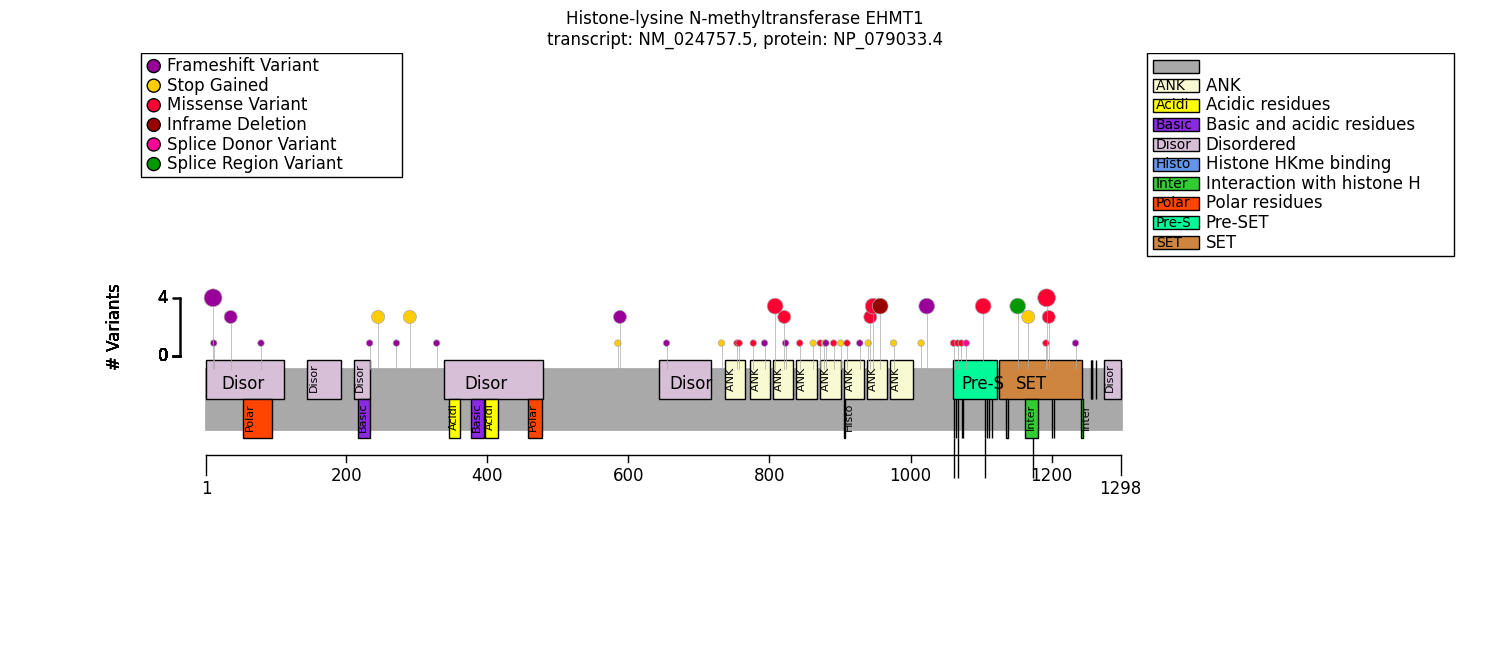

In [9]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

ehmt1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
ehmt1_fig.tight_layout()

In [10]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort)

Count,Name,Type,Coordinates,Variants
8,Disordered,Region,2 - 111,p.Gln82ArgfsTer7; p.Glu14SerfsTer8; p.Arg12ThrfsTer25; p.Glu14GlyfsTer23; p.Gly37ValfsTer17
1,Polar residues,Compositional bias,55 - 94,p.Gln82ArgfsTer7
0,Disordered,Region,145 - 192,
1,Disordered,Region,212 - 234,p.Glu236ArgfsTer47
1,Basic and acidic residues,Compositional bias,217 - 234,p.Glu236ArgfsTer47
0,Disordered,Region,340 - 479,
0,Acidic residues,Compositional bias,346 - 361,
0,Basic and acidic residues,Compositional bias,378 - 395,
0,Acidic residues,Compositional bias,397 - 415,
0,Polar residues,Compositional bias,458 - 477,


In [9]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
40,SO:1000029_HGNC:24650_EHMT1,SV involving EHMT1 (p.?),,chromosomal deletion
3,9_137815998_137815998_G_A,c.3310G>A (p.Glu1104Lys),23,missense
3,SO:1000037_HGNC:24650_EHMT1,SV involving EHMT1 (p.?),,chromosomal duplication
3,9_137813009_137813015_CTTTCTT_C,c.2873_2878del (p.Phe958_Leu959del),20,inframe deletion
3,9_137811590_137811590_C_T,c.2842C>T (p.Arg948Trp),19,missense
3,9_137790891_137790891_C_T,c.2426C>T (p.Pro809Leu),16,missense
3,9_137813421_137813423_CCT_C,c.3072_3073del (p.Val1026GlnfsTer150),21,frameshift
2,9_137834389_137834389_A_T,c.3581A>T (p.Asn1194Ile),26,missense
2,9_137811578_137811578_C_T,c.2830C>T (p.His944Tyr),19,missense
2,9_137716649_137716649_G_AT,c.109_110insT (p.Gly37ValfsTer17),3,frameshift


# Genotype-Phenotype Correlation (GPC) Analysis

In [11]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
analysis = configure_hpo_term_analysis(hpo)

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label='Missense', 
    b_label='Other'
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

from gpsea.view import MtcStatsViewer
mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,45
HMF08,Skipping general term,52
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,101


In [13]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group                                 Missense          Other          \
                                                Count Percent  Count Percent   
Recurrent infections [HP:0002719]                9/12     75%  49/50     98%   
Hearing impairment [HP:0000365]                  4/23     17%  31/73     42%   
Chronic constipation [HP:0012450]                9/26     35%  50/92     54%   
Autism [HP:0000717]                              9/22     41%  46/81     57%   
Global developmental delay [HP:0001263]         27/28     96%  86/95     91%   
Overweight [HP:0025502]                         10/23     43%  29/85     34%   
Intellectual disability [HP:0001249]            24/28     86%  87/96     91%   
Increased body weight [HP:0004324]              15/15    100%  45/45    100%   
Neurodevelopmental abnormality [HP:0012759]     27/27    100%  91/91    100%   
Neurodevelopmental delay [HP:0012758]           27/27    100%  86/86    100%   
Recurrent maladaptive behavior [HP:5200241]       8/8    100%  42/42    100%   
Atypical behavior [HP:0000708]                  14/14    100%  67/67    100%   
Autistic behavior [HP:0000729]                    9/9    100%  46/46    100%   
Diagnostic behavioral phenotype [HP:0025783]      9/9    100%  46/46    100%   
Abdominal symptom [HP:0011458]                  13/13    100%  66/66    100%   
Unusual infection [HP:0032101]                    9/9    100%  49/49    100%   
Constipation [HP:0002019]                         9/9    100%  50/50    100%   

Allele group                                                               
                                             Corrected p values  p values  
Recurrent infections [HP:0002719]                      0.350303  0.020606  
Hearing impairment [HP:0000365]                        0.385665  0.045372  
Chronic constipation [HP:0012450]                      0.674290  0.118992  
Autism [HP:0000717]                                    0.981656  0.230978  
Global developmental delay [HP:0001263]                1.000000  0.452424  
Overweight [HP:0025502]                                1.000000  0.466338  
Intellectual disability [HP:0001249]                   1.000000  0.487684  
Increased body weight [HP:0004324]                     1.000000  1.000000  
Neurodevelopmental abnormality [HP:0012759]            1.000000  1.000000  
Neurodevelopmental delay [HP:0012758]                  1.000000  1.000000  
Recurrent maladaptive behavior [HP:5200241]            1.000000  1.000000  
Atypical behavior [HP:0000708]                         1.000000  1.000000  
Autistic behavior [HP:0000729]                         1.000000  1.000000  
Diagnostic behavioral phenotype [HP:0025783]           1.000000  1.000000  
Abdominal symptom [HP:0011458]                         1.000000  1.000000  
Unusual infection [HP:0032101]                         1.000000  1.000000  
Constipation [HP:0002019]                              1.000000  1.000000

Lets also try to investigate a possible sex difference, since this has been previously mentioned in Kleefstra. 

In [14]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                          FEMALE           MALE          \
                                              Count Percent  Count Percent   
Hearing impairment [HP:0000365]               19/62     31%  16/35     46%   
Chronic constipation [HP:0012450]             42/79     53%  17/40     42%   
Hypotonia [HP:0001252]                        33/81     41%  16/44     36%   
Intellectual disability [HP:0001249]          73/81     90%  39/44     89%   
Autism [HP:0000717]                           39/72     54%  16/32     50%   
Increased body weight [HP:0004324]            41/41    100%  20/20    100%   
Neurodevelopmental abnormality [HP:0012759]   77/77    100%  42/42    100%   
Global developmental delay [HP:0001263]       73/80     91%  41/44     93%   
Neurodevelopmental delay [HP:0012758]         73/73    100%  41/41    100%   
Recurrent maladaptive behavior [HP:5200241]   40/40    100%  11/11    100%   
Atypical behavior [HP:0000708]                59/59    100%  23/23    100%   
Autistic behavior [HP:0000729]                39/39    100%  16/16    100%   
Diagnostic behavioral phenotype [HP:0025783]  39/39    100%  16/16    100%   
Abdominal symptom [HP:0011458]                53/53    100%  26/26    100%   
Recurrent infections [HP:0002719]             34/36     94%  24/26     92%   
Unusual infection [HP:0032101]                34/34    100%  24/24    100%   
Constipation [HP:0002019]                     42/42    100%  17/17    100%   

Sex                                                                        
                                             Corrected p values  p values  
Hearing impairment [HP:0000365]                             1.0  0.186638  
Chronic constipation [HP:0012450]                           1.0  0.332985  
Hypotonia [HP:0001252]                                      1.0  0.703179  
Intellectual disability [HP:0001249]                        1.0  0.768708  
Autism [HP:0000717]                                         1.0  0.831770  
Increased body weight [HP:0004324]                          1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                 1.0  1.000000  
Global developmental delay [HP:0001263]                     1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                       1.0  1.000000  
Recurrent maladaptive behavior [HP:5200241]                 1.0  1.000000  
Atypical behavior [HP:0000708]                              1.0  1.000000  
Autistic behavior [HP:0000729]                              1.0  1.000000  
Diagnostic behavioral phenotype [HP:0025783]                1.0  1.000000  
Abdominal symptom [HP:0011458]                              1.0  1.000000  
Recurrent infections [HP:0002719]                           1.0  1.000000  
Unusual infection [HP:0032101]                              1.0  1.000000  
Constipation [HP:0002019]                                   1.0  1.000000

In [15]:
from gpsea.analysis.predicate import exon, anyof, allof
exon1 = exon(exon=1, tx_id=mane_tx_id)
exon2 = exon(exon=2, tx_id=mane_tx_id)
exon3 = exon(exon=3, tx_id=mane_tx_id)
frameshift = variant_effect(effect=VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)

n_term = anyof((exon1, exon2, exon3))
n_term_fs = allof((n_term, frameshift))

n_term_fs_clf = monoallelic_classifier(
    a_predicate=n_term_fs,
    b_predicate=~n_term_fs,
    a_label="N Term Frameshift",
    b_label="other"
)
n_term_fs_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_fs_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, n_term_fs_result)

Allele group                                       N Term Frameshift          \
                                                               Count Percent   
Attention deficit hyperactivity disorder [HP:00...               4/8     50%   
Intellectual disability [HP:0001249]                             4/8     50%   
Global developmental delay [HP:0001263]                          4/7     57%   
Chronic constipation [HP:0012450]                                0/7      0%   
Obesity [HP:0001513]                                             3/6     50%   
Anxiety [HP:0000739]                                             4/8     50%   
Hypotonia [HP:0001252]                                           1/8     12%   
Large for gestational age [HP:0001520]                           2/4     50%   
Autism [HP:0000717]                                              3/8     38%   
Strabismus [HP:0000486]                                          2/5     40%   
Hearing impairment [HP:0000365]                                  3/7     43%   
Increased body weight [HP:0004324]                               6/6    100%   
Neurodevelopmental abnormality [HP:0012759]                      6/6    100%   
Neurodevelopmental delay [HP:0012758]                            4/4    100%   
Recurrent maladaptive behavior [HP:5200241]                      4/4    100%   
Atypical behavior [HP:0000708]                                   6/6    100%   
Autistic behavior [HP:0000729]                                   3/3    100%   
Diagnostic behavioral phenotype [HP:0025783]                     3/3    100%   
Recurrent infections [HP:0002719]                                2/2    100%   
Unusual infection [HP:0032101]                                   2/2    100%   

Allele group                                          other          \
                                                      Count Percent   
Attention deficit hyperactivity disorder [HP:00...     3/95      3%   
Intellectual disability [HP:0001249]                107/116     92%   
Global developmental delay [HP:0001263]             109/116     94%   
Chronic constipation [HP:0012450]                    59/111     53%   
Obesity [HP:0001513]                                  9/102      9%   
Anxiety [HP:0000739]                                  22/95     23%   
Hypotonia [HP:0001252]                               47/116     41%   
Large for gestational age [HP:0001520]                17/86     20%   
Autism [HP:0000717]                                   52/95     55%   
Strabismus [HP:0000486]                               22/71     31%   
Hearing impairment [HP:0000365]                       32/89     36%   
Increased body weight [HP:0004324]                    54/54    100%   
Neurodevelopmental abnormality [HP:0012759]         112/112    100%   
Neurodevelopmental delay [HP:0012758]               109/109    100%   
Recurrent maladaptive behavior [HP:5200241]           46/46    100%   
Atypical behavior [HP:0000708]                        75/75    100%   
Autistic behavior [HP:0000729]                        52/52    100%   
Diagnostic behavioral phenotype [HP:0025783]          52/52    100%   
Recurrent infections [HP:0002719]                     56/60     93%   
Unusual infection [HP:0032101]                        56/56    100%   

Allele group                                                           \
                                                   Corrected p values   
Attention deficit hyperactivity disorder [HP:00...           0.010035   
Intellectual disability [HP:0001249]                         0.041587   
Global developmental delay [HP:0001263]                      0.064707   
Chronic constipation [HP:0012450]                            0.064707   
Obesity [HP:0001513]                                         0.070586   
Anxiety [HP:0000739]                                         0.361273   
Hypotonia [HP:0001252]                                       0.427546   
Large for gestation

In [16]:
ablation = variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)

ablation_clf = monoallelic_classifier(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="CNV",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, ablation_result)

Allele group                                    CNV          other          \
                                              Count Percent  Count Percent   
Microcephaly [HP:0000252]                     15/26     58%  10/75     13%   
Chronic constipation [HP:0012450]             27/39     69%  32/79     41%   
Intellectual disability [HP:0001249]          39/40     98%  72/84     86%   
Hearing impairment [HP:0000365]               13/29     45%  22/67     33%   
Global developmental delay [HP:0001263]       38/40     95%  75/83     90%   
Hypotonia [HP:0001252]                        17/40     42%  31/84     37%   
Increased body weight [HP:0004324]            14/14    100%  46/46    100%   
Neurodevelopmental abnormality [HP:0012759]   40/40    100%  78/78    100%   
Neurodevelopmental delay [HP:0012758]         38/38    100%  75/75    100%   
Recurrent maladaptive behavior [HP:5200241]   16/16    100%  34/34    100%   
Atypical behavior [HP:0000708]                25/25    100%  56/56    100%   
Autism [HP:0000717]                           18/34     53%  37/69     54%   
Autistic behavior [HP:0000729]                18/18    100%  37/37    100%   
Diagnostic behavioral phenotype [HP:0025783]  18/18    100%  37/37    100%   
Abdominal symptom [HP:0011458]                30/30    100%  49/49    100%   
Recurrent infections [HP:0002719]             22/23     96%  36/39     92%   
Unusual infection [HP:0032101]                22/22    100%  36/36    100%   
Constipation [HP:0002019]                     27/27    100%  32/32    100%   

Allele group                                                               
                                             Corrected p values  p values  
Microcephaly [HP:0000252]                              0.000398  0.000022  
Chronic constipation [HP:0012450]                      0.052075  0.005786  
Intellectual disability [HP:0001249]                   0.355837  0.059306  
Hearing impairment [HP:0000365]                        1.000000  0.355823  
Global developmental delay [HP:0001263]                1.000000  0.496622  
Hypotonia [HP:0001252]                                 1.000000  0.560532  
Increased body weight [HP:0004324]                     1.000000  1.000000  
Neurodevelopmental abnormality [HP:0012759]            1.000000  1.000000  
Neurodevelopmental delay [HP:0012758]                  1.000000  1.000000  
Recurrent maladaptive behavior [HP:5200241]            1.000000  1.000000  
Atypical behavior [HP:0000708]                         1.000000  1.000000  
Autism [HP:0000717]                                    1.000000  1.000000  
Autistic behavior [HP:0000729]                         1.000000  1.000000  
Diagnostic behavioral phenotype [HP:0025783]           1.000000  1.000000  
Abdominal symptom [HP:0011458]                         1.000000  1.000000  
Recurrent infections [HP:0002719]                      1.000000  1.000000  
Unusual infection [HP:0032101]                         1.000000  1.000000  
Constipation [HP:0002019]                              1.000000  1.000000

# 
The eight individuals with a PAV in the ANKR domain had a higher IQ (mean IQ 65 vs. 54, p = 0.03). Furthermore, feeding difficulties were significantly less prevalent (3/20 vs. 20/47, p = 0.03), as well as structural heart defects (2/20 vs. 15/47, p = 0.06), and recurrent infections had a lower prevalence (6/20 vs. 27/47, p = 0.04). Similarly, the five individuals with a PAV in the SET domain also had a higher IQ (mean IQ 66 vs. 54, p = 0.04) and lower prevalence of recurrent infections (3/13 vs. 27/47, p = 0.03) (Figure S6).

In [17]:
from gpsea.analysis.predicate import protein_feature
## ankyrin repeat (ANK) domain
ank1 = protein_feature(feature_id="ANK 1", protein_metadata=protein_meta) #737 - 766	
ank2 = protein_feature(feature_id="ANK 2", protein_metadata=protein_meta) #772 - 801
ank3 = protein_feature(feature_id="ANK 3", protein_metadata=protein_meta) #805 - 834
ank4 = protein_feature(feature_id="ANK 4", protein_metadata=protein_meta) #838 - 868
ank5 = protein_feature(feature_id="ANK 5", protein_metadata=protein_meta) #872 - 901
ank6 = protein_feature(feature_id="ANK 6", protein_metadata=protein_meta) #905 - 934	

ank_repeat = anyof((ank1, ank2, ank3, ank4, ank5, ank6))

ank_repeat_clf = monoallelic_classifier(
    a_predicate=ank_repeat,
    b_predicate=~ank_repeat,
    a_label="ANKR",
    b_label="other"
)

ank_repeat_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ank_repeat_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, ank_repeat_result)

Allele group                                   ANKR            other          \
                                              Count Percent    Count Percent   
Recurrent infections [HP:0002719]             11/13     85%    47/49     96%   
Intellectual disability [HP:0001249]          15/18     83%   96/106     91%   
Hypotonia [HP:0001252]                         5/18     28%   43/106     41%   
Hearing impairment [HP:0000365]                6/13     46%    29/83     35%   
Chronic constipation [HP:0012450]              7/17     41%   52/101     51%   
Overweight [HP:0025502]                        6/15     40%    33/93     35%   
Increased body weight [HP:0004324]              8/8    100%    52/52    100%   
Neurodevelopmental abnormality [HP:0012759]   17/17    100%  101/101    100%   
Global developmental delay [HP:0001263]       17/18     94%   96/105     91%   
Neurodevelopmental delay [HP:0012758]         17/17    100%    96/96    100%   
Recurrent maladaptive behavior [HP:5200241]     7/7    100%    43/43    100%   
Atypical behavior [HP:0000708]                12/12    100%    69/69    100%   
Autism [HP:0000717]                            9/16     56%    46/87     53%   
Autistic behavior [HP:0000729]                  9/9    100%    46/46    100%   
Diagnostic behavioral phenotype [HP:0025783]    9/9    100%    46/46    100%   
Abdominal symptom [HP:0011458]                12/12    100%    67/67    100%   
Unusual infection [HP:0032101]                11/11    100%    47/47    100%   
Constipation [HP:0002019]                       7/7    100%    52/52    100%   

Allele group                                                               
                                             Corrected p values  p values  
Recurrent infections [HP:0002719]                           1.0  0.190836  
Intellectual disability [HP:0001249]                        1.0  0.401246  
Hypotonia [HP:0001252]                                      1.0  0.433522  
Hearing impairment [HP:0000365]                             1.0  0.538193  
Chronic constipation [HP:0012450]                           1.0  0.601157  
Overweight [HP:0025502]                                     1.0  0.776432  
Increased body weight [HP:0004324]                          1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                 1.0  1.000000  
Global developmental delay [HP:0001263]                     1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                       1.0  1.000000  
Recurrent maladaptive behavior [HP:5200241]                 1.0  1.000000  
Atypical behavior [HP:0000708]                              1.0  1.000000  
Autism [HP:0000717]                                         1.0  1.000000  
Autistic behavior [HP:0000729]                              1.0  1.000000  
Diagnostic behavioral phenotype [HP:0025783]                1.0  1.000000  
Abdominal symptom [HP:0011458]                              1.0  1.000000  
Unusual infection [HP:0032101]                              1.0  1.000000  
Constipation [HP:0002019]                                   1.0  1.000000

In [18]:
set_domain = protein_feature(feature_id="SET", protein_metadata=protein_meta)

set_clf = monoallelic_classifier(
    a_predicate=set_domain,
    b_predicate=~set_domain,
    a_label="SET",
    b_label="other"
)

set_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=set_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, set_result)

Allele group                                    SET            other          \
                                              Count Percent    Count Percent   
Intellectual disability [HP:0001249]          13/13    100%   98/111     88%   
Autism [HP:0000717]                             3/8     38%    52/95     55%   
Overweight [HP:0025502]                        5/11     45%    34/97     35%   
Chronic constipation [HP:0012450]              5/13     38%   54/105     51%   
Global developmental delay [HP:0001263]       13/13    100%  100/110     91%   
Increased body weight [HP:0004324]              6/6    100%    54/54    100%   
Neurodevelopmental abnormality [HP:0012759]   13/13    100%  105/105    100%   
Neurodevelopmental delay [HP:0012758]         13/13    100%  100/100    100%   
Recurrent maladaptive behavior [HP:5200241]     4/4    100%    46/46    100%   
Atypical behavior [HP:0000708]                  7/7    100%    74/74    100%   
Autistic behavior [HP:0000729]                  3/3    100%    52/52    100%   
Diagnostic behavioral phenotype [HP:0025783]    3/3    100%    52/52    100%   
Abdominal symptom [HP:0011458]                  7/7    100%    72/72    100%   
Recurrent infections [HP:0002719]               7/7    100%    51/55     93%   
Unusual infection [HP:0032101]                  7/7    100%    51/51    100%   
Constipation [HP:0002019]                       5/5    100%    54/54    100%   

Allele group                                                               
                                             Corrected p values  p values  
Intellectual disability [HP:0001249]                        1.0  0.357272  
Autism [HP:0000717]                                         1.0  0.467824  
Overweight [HP:0025502]                                     1.0  0.521267  
Chronic constipation [HP:0012450]                           1.0  0.558082  
Global developmental delay [HP:0001263]                     1.0  0.597627  
Increased body weight [HP:0004324]                          1.0  1.000000  
Neurodevelopmental abnormality [HP:0012759]                 1.0  1.000000  
Neurodevelopmental delay [HP:0012758]                       1.0  1.000000  
Recurrent maladaptive behavior [HP:5200241]                 1.0  1.000000  
Atypical behavior [HP:0000708]                              1.0  1.000000  
Autistic behavior [HP:0000729]                              1.0  1.000000  
Diagnostic behavioral phenotype [HP:0025783]                1.0  1.000000  
Abdominal symptom [HP:0011458]                              1.0  1.000000  
Recurrent infections [HP:0002719]                           1.0  1.000000  
Unusual infection [HP:0032101]                              1.0  1.000000  
Constipation [HP:0002019]                                   1.0  1.000000

# Summary

In [19]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ), GPAnalysisResultSummary.from_multi(
        result=n_term_fs_result,
    ), GPAnalysisResultSummary.from_multi(
        result=ank_repeat_result,
    ), GPAnalysisResultSummary.from_multi(
        result=set_result,
    ),
)

caption = "Rots et al. reported several correlations in PMID_39013458. Multiple-testing correction was not performed. Frazier et al (2025) also reported significant correlations but the original data was not made available. PMID_39746677"

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption
)

In [20]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [21]:
summarizer.process_latex(report=report, protein_fig=ehmt1_fig)

Figure saved to ../../supplement/img/EHMT1_protein_diagram-draft.pdf
Output to ../../supplement/tex/EHMT1_summary_draft.tex
